# Data Analisis Assignment - Group 1
## Introduction
The goal of this project is to analyze hourly electricity generation in Spain, broken down by autonomous community and generation technology. We aim to extract and explore key insights from the data, identify regional and technological trends, and optionally examine correlations between different data sources.
## Task 1: Data Extraction and Saving
The data extraction process is carried out through the Red Eléctrica de España (REE) API. An interactive user interface allows users to input the desired autonomous community, time period, and generation technology. Based on these inputs, the program retrieves the corresponding hourly electricity generation data and exports it to an Excel file named in the format: "Generation_[AutonomousCommunity][StartDate][EndDate]".

__Inputs:__
- Region Code
- Technology
- Start Date
- End Date

__Output:__
- Excel file with columns: datetime, value by technology, percentage value by technology

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime as dt

# Geo_id per region according to the REE API:
# https://www.ree.es/es/datos/apidatos
# ───────────────────────────────────────────────────────────────────────────
# 1. Dictionary REGIONS  →  readable key  →  API id
# ───────────────────────────────────────────────────────────────────────────
REGIONES = {
    "Andalucía": 4,
    "Aragón": 5,
    "Cantabria": 6,
    "Asturias": 11,
    "Castilla y León": 8,
    "Castilla-La Mancha": 7,
    "Cataluña": 9,
    "Comunidad Valenciana": 15,
    "Extremadura": 16,
    "Galicia": 17,
    "Madrid": 8752,
    "Murcia": 21,
    "Navarra": 14,
    "País Vasco": 10,
    "La Rioja": 20,
    "Islas Baleares": 8743,
    "Islas Canarias": 8742,
    "Ceuta": 8744,
    "Melilla": 8745,
    "Península": 8741,
}

# ───────────────────────────────────────────────────────────────────────────
# 2. Interactive selection (region + dates)
# ───────────────────────────────────────────────────────────────────────────
print("╔══════════════════════════════════════════╗")
print("║   Available Regions (geo_limit=ccaa)     ║")
print("╚══════════════════════════════════════════╝")
for n, reg in enumerate(REGIONES, 1):
    print(f"{n:>2}. {reg}")

# --- Select region ---
while True:
    try:
        idx = int(input("\nNumber of desired region: "))
        region_name = list(REGIONES)[idx - 1]
        geo_id = REGIONES[region_name]
        break
    except (ValueError, IndexError):
        print("⛔ Invalid choice, try again…")

# --- Date input ---
def ask_date(prompt):
    while True:
        try:
            txt = input(prompt)
            return dt.strptime(txt.strip(), "%Y-%m-%d %H:%M")
        except ValueError:
            print("⛔ Invalid format. Example: 2019-01-01 00:00")

start = ask_date("\nStart date (YYYY-MM-DD HH:MM): ")
end   = ask_date("End date   (YYYY-MM-DD HH:MM): ")
if end <= start:
    raise ValueError("End date must be after the start date.")

print(f"\n▶ Region: {region_name}  (geo_id = {geo_id})")
print(f"▶ Period: {start}  →  {end}\n")

# ───────────────────────────────────────────────────────────────────────────
# 3. API call function (daily granularity)
# ───────────────────────────────────────────────────────────────────────────
def get_gen(geo_id, start_date, end_date):
    url = "https://apidatos.ree.es/es/datos/generacion/estructura-generacion"

    headers = {
        "Accept": "application/json",
    }

    params = {
        "start_date": start_date,
        "end_date": end_date,
        "time_trunc": "day",
        "geo_limit":  "ccaa",
        "geo_id": geo_id
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"⛔ Error {response.status_code}")
        print(response.text)
        return pd.DataFrame()  # <- Return empty DataFrame on failure

    data = response.json()

    # Extract generation data
    rows = []
    for technology in data["included"]:
        name = technology["attributes"]["title"]
        for v in technology["attributes"]["values"]:
            rows.append({
                "datetime": v["datetime"],
                "value": v["value"],
                "percentage": v["percentage"],
                "technology": name
            })

    return pd.DataFrame(rows)

# Call API
df = get_gen(geo_id, start, end)


if df.empty:
    print("❗ No data found. Please verify your input.")
else:
    print(df.head())
    # Format dates to string
    start_str = start.strftime("%Y%m%d")
    end_str   = end.strftime("%Y%m%d")

    # Export to Excel
    archivo_excel = f"generacion_{region_name.replace(' ', '_').lower()}_{start_str}_{end_str}.xlsx"
    df.to_excel(archivo_excel, index=False)
    print(f"✅ Data saved to: {archivo_excel}")

╔══════════════════════════════════════════╗
║   Available Regions (geo_limit=ccaa)     ║
╚══════════════════════════════════════════╝
 1. Andalucía
 2. Aragón
 3. Cantabria
 4. Asturias
 5. Castilla y León
 6. Castilla-La Mancha
 7. Cataluña
 8. Comunidad Valenciana
 9. Extremadura
10. Galicia
11. Madrid
12. Murcia
13. Navarra
14. País Vasco
15. La Rioja
16. Islas Baleares
17. Islas Canarias
18. Ceuta
19. Melilla
20. Península

Number of desired region: 20

Start date (YYYY-MM-DD HH:MM): 2020-05-07 00:00
End date   (YYYY-MM-DD HH:MM): 20-08–03 00:00
⛔ Invalid format. Example: 2019-01-01 00:00
End date   (YYYY-MM-DD HH:MM): 2020-08–03 00:00
⛔ Invalid format. Example: 2019-01-01 00:00
End date   (YYYY-MM-DD HH:MM): 2020-08–03 00:00
⛔ Invalid format. Example: 2019-01-01 00:00
End date   (YYYY-MM-DD HH:MM): 2020-09-01 00:00

▶ Region: Península  (geo_id = 8741)
▶ Period: 2020-05-07 00:00:00  →  2020-09-01 00:00:00

                        datetime       value  percentage  technology
0  20

## Task 2: Data Preprocessing and Cleaning

__Inputs:__
- dataframe "df" with columns: datetime, value percentage, technology

__Output:__
- dataframe "df" with columns: datetime, value percentage, technology

In [2]:
# Display the top 5 rows of the Dataframe
df.head()

,datetime,value,percentage,technology
0,2020-05-07T00:00:00.000+02:00,117851.691,0.196091,Hidráulica
1,2020-05-08T00:00:00.000+02:00,108692.780,0.189888,Hidráulica
2,2020-05-09T00:00:00.000+02:00,95552.021,0.174404,Hidráulica
3,2020-05-10T00:00:00.000+02:00,84863.512,0.153187,Hidráulica
4,2020-05-11T00:00:00.000+02:00,94381.696,0.159269,Hidráulica


In [3]:
# Display information about the data including the index dtype and columns, non-null values and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1948 entries, 0 to 1947
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    1948 non-null   object 
 1   value       1948 non-null   float64
 2   percentage  1948 non-null   float64
 3   technology  1948 non-null   object 
dtypes: float64(2), object(2)
memory usage: 61.0+ KB


In [4]:
# Display descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.
df.describe()

,value,percentage
count,1.948000e+03,1.948000e+03
mean,1.705772e+05,1.211499e-01
std,1.085046e+06,2.366502e-01
min,-1.016000e+00,4.390372e-09
25%,4.334738e+03,5.354510e-03
50%,1.756799e+04,2.036025e-02
75%,8.776074e+04,1.216440e-01
max,2.453215e+07,1.000000e+00


In [5]:
# Check data for missing values
missing_values = df.isnull().sum()

# Filter columns with missing values
missing_cols = missing_values[missing_values > 0]

# Print results
if missing_cols.empty:
    print("No null values found.")
else:
    print("Missing values found in the following columns:")
    print(missing_cols)
    print("\nPossible treatments:")
    print("- Drop rows with missing values: df.dropna(inplace=True)")
    print("- Fill missing values (example: fill with mean): df.fillna(df.mean(), inplace=True)")

No null values found.


In [6]:
# Check data for outliers values
import pandas as pd

# Example: df is already loaded and has the columns: datetime, value, percentage, technology

# Select only numeric columns to check for outliers
numeric_cols = ['value', 'percentage']

outlier_report = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    if not outliers.empty:
        outlier_report[col] = len(outliers)

# Print summary
if not outlier_report:
    print("No outliers found in numeric columns.")
else:
    print("Outliers found in the following columns:")
    for col, count in outlier_report.items():
        print(f"- {col}: {count} outliers")

    print("\nPossible treatments:")
    print("- Remove outliers: df = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]  # Repeat for each column")
    print("- Replace outliers (e.g., with median): df['value'] = np.where((df['value'] < lower_bound) | (df['value'] > upper_bound), df['value'].median(), df['value'])")

Outliers found in the following columns:
- value: 174 outliers
- percentage: 136 outliers

Possible treatments:
- Remove outliers: df = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]  # Repeat for each column
- Replace outliers (e.g., with median): df['value'] = np.where((df['value'] < lower_bound) | (df['value'] > upper_bound), df['value'].median(), df['value'])


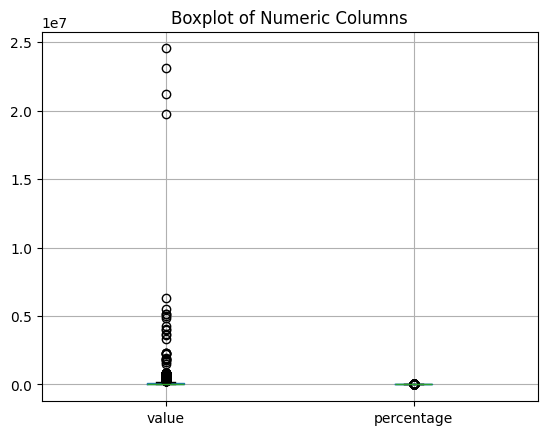

In [7]:
# Add some box plots to visualise the outliers, if there are some
import matplotlib.pyplot as plt

df[numeric_cols].boxplot()
plt.title("Boxplot of Numeric Columns")
plt.show()

In [7]:
# Check data for dublicate values
# *insert code here, Use .duplicated() to identify and .drop_duplicates() to remove them. Output can be a sentence like: No dublicates found; or if there are some how they were treated*

## Task 3: Data Visualization and Insights Extraction

This code transforms raw time-series (hourly or daily) data into insightful visualizations by aggregating daily generation values by different time periods (day, week, month, year) and demonstating them by technology type.

__Inputs:__
- Excel File "Generation_[AutonomousCommunity][StartDate][EndDate]"

## To-dos for Taks 3:

Quitar Generacion Total de la lista antes de hacer graphs
Something is wrong with the 1st or last day of the month or the range - looks like it is showing monthly aggregated value maybe, but why?

### Current charts:
Bar chart, each bar is date, made up of technologies
Repeat for %

Pivot this table and do it for 1 tech only, showing production for each day
Repeat for %

### Upgrade the code:
Wrap up into a generalized function that lets you pick the aggregation level upfront: "day", "week", "month", or "year”.
Edit code so it asks for just month and just year, or just truncate it like daily/weekly code does now (and include only full week/mo/year)

### added to Yan's original code:
import matplotlib.pyplot as plt
The following sums values for the whole day, in case hourly data becomes available in this API in the future
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))   — so the Legend is not in the middle of the plot


In [8]:
# Daily Energy Generation Bar Graph by Technology
# It goes from 01 to 23h by month. Check the range of dates available in the API
# This sums hourly values for each day, in case hourly data becomes available in this widget in the future

import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

pivot_df = df.pivot_table(
    index="date",
    columns="technology",
    values="value",
    aggfunc="sum",
    fill_value=0
    )

pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Daily generation by technology in Spain",
    )

plt.xlabel("Date")
plt.ylabel("Generation (MWh)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

<ipython-input-8-d5efafc0bfe2>:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["date"] = pd.to_datetime(df["datetime"]).dt.date


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
print(df["datetime"].head(10))


In [ ]:
# Weekly Energy Generation Bar Graph by Technology (truncated to full weeks only, Mon-Sun)

import pandas as pd
import matplotlib.pyplot as plt

df["datetime"] = pd.to_datetime(df["datetime"])
df["date"] = df["datetime"].dt.date

# Add week column, where week starts on Monday
df["week"] = df["datetime"].dt.to_period("W-MON")

daily_pivot = df.pivot_table(
    index="date",
    columns="technology",
    values="value",
    aggfunc="sum",
    fill_value=0
)

daily_pivot["week"] = pd.to_datetime(daily_pivot.index).to_series().dt.to_period("W-MON").values

# Group by week and average daily values
weekly_avg = daily_pivot.groupby("week").mean()

# Keep only full weeks, i.e. weeks that have exactly 7 daily records in original data
full_weeks = daily_pivot.groupby("week").size()
weekly_avg = weekly_avg.loc[full_weeks[full_weeks == 7].index]

weekly_avg.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Average weekly generation by technology"
)

plt.xlabel("Week")
plt.ylabel("Average Daily Generation (MWh)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
# Monthly Energy Generation Bar Graph by Technology (truncated to full months only)
# We should change the original request to be time_trunc = "month"

import pandas as pd
import matplotlib.pyplot as plt

df["datetime"] = pd.to_datetime(df["datetime"])
df["date"] = df["datetime"].dt.date
df["month"] = df["datetime"].dt.to_period("M")  # format 2024-05


daily_pivot = df.pivot_table(
    index="date",
    columns="technology",
    values="value",
    aggfunc="sum",
    fill_value=0
)

daily_pivot["month"] = pd.to_datetime(daily_pivot.index).to_series().dt.to_period("M").values

# Keep only full months (i.e., months with all days present)
# should check for the actual # days; but if we just time_trunc by month it's not necessary
days_in_month = daily_pivot.groupby("month").size()
full_months = days_in_month[days_in_month >= 28]

monthly_avg = daily_pivot.groupby("month").mean()
monthly_avg = monthly_avg.loc[full_months.index]

monthly_avg.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Average daily generation by technology (monthly, full months only)"
)

plt.xlabel("Month")
plt.ylabel("Average Daily Generation (MWh)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
# Yearly Energy Generation Bar Graph by Technology (truncated to full years only)
# Currently this doesn't work - seems to be too much data to pull at once
# We should change the original request to be time_trunc = "year" and make code
# similar to updated month code = similar to original daily code

df["year"] = df["datetime"].dt.year

daily_pivot["year"] = pd.to_datetime(daily_pivot.index).to_series().dt.year

# Keep only full years (365 or 366 days) -- not necessary after time_trunc = year
days_in_year = daily_pivot.groupby("year").size()
full_years = days_in_year[days_in_year >= 365]

yearly_avg = daily_pivot.groupby("year").mean()
yearly_avg = yearly_avg.loc[full_years.index]

yearly_avg.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    title="Average daily generation by technology (yearly, full years only)"
)

plt.xlabel("Year")
plt.ylabel("Average Daily Generation (MWh)")
plt.xticks(rotation=0)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
# Daily Energy Generation Line Charts by Technology
# This script lets the user select a technology from the dataset and shows two line charts:
# one for daily total production (in MWh) and one for average daily percentage.
# It groups and sums values by day to visualize trends over time.
import pandas as pd
import matplotlib.pyplot as plt


# Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

#Get unique technologies and create the dynamic menu
tech_list = sorted(df['technology'].unique())

# Menu and input loop
selected_tech = None
while selected_tech is None:
    print("\nSelect a technology to generate the chart:\n")
    for idx, tech in enumerate(tech_list, start=1):
        print(f"{idx}. {tech}")

    user_input = input("\nEnter the number of the selected technology: ")
    try:
        choice = int(user_input)
        if 1 <= choice <= len(tech_list):
            selected_tech = tech_list[choice - 1]
        else:
            print("Number out of range. Please try again.")
    except ValueError:
        print("Invalid input. Please enter a number.")

print(f"\nYou selected: {selected_tech}")

#Filter data
df_filtered = df[df['technology'] == selected_tech]

# Step 5: Group by day
grouped = df_filtered.groupby('date').agg({
    'value': 'sum',
    'percentage': 'mean'
}).reset_index()

# Step 6: Plot charts
plt.figure(figsize=(14, 6))

# Production plot
plt.subplot(2, 1, 1)
plt.plot(grouped['date'], grouped['value'], marker='o')
plt.title(f'Daily Production - {selected_tech}')
plt.ylabel('Production (MWh)')
plt.grid(True)

# Percentage plot
plt.subplot(2, 1, 2)
plt.plot(grouped['date'], grouped['percentage'], marker='o', color='orange')
plt.title(f'Daily Share of Total Production - {selected_tech}')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()

## Task 4: Comparison of the results of the different sources

__Inputs:__
- Data of Red Eléctrica de España (REE) API
- Wind data from maritime observations in NOOA corresponding to the Spanish coasts (Group 4)